IMAGE RECOGNITION

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
# Load pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')


In [ ]:
def load_and_preprocess_image(image_path):
    # Load and preprocess image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, so convert to RGB
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21) # to remove noise in the image dataset
    img = cv2.resize(img, (224, 224))  # Resize image to the input size expected by ResNet50
    img_array = np.expand_dims(img, axis=0)
    return preprocess_input(img_array)

def extract_features(image_path, model):
    # Extract features from the image using the pre-trained model
    img = load_and_preprocess_image(image_path)
    features = model.predict(img)
    return features.flatten()


In [ ]:
def find_most_similar_product(user_features, database_features):
    # Find the most similar product based on cosine similarity
    similarities = cosine_similarity([user_features], database_features)
    most_similar_index = np.argmax(similarities)
    return most_similar_index


In [ ]:
# Setting our database path
database_path = r'C:\Users\Lenovo\Documents\ML POC\Step-2\Product Database\DB - 4\downloaded_images'
database_images = [os.path.join(database_path, img) for img in os.listdir(database_path)]
database_features = [extract_features(img_path, base_model) for img_path in database_images]


1/1 [==============================] - 1s 732ms/step


In [ ]:
# user image path
user_image_path = r'C:\Users\Lenovo\Documents\ML POC\image\db.jpg'
user_features = extract_features(user_image_path, base_model)


1/1 [==============================] - 0s 105ms/step


In [ ]:
# Find the most similar product
most_similar_index = find_most_similar_product(user_features, database_features)
most_similar_image_path = database_images[most_similar_index]

In [ ]:
# Extract the ID from the image filename
most_similar_image_id = os.path.splitext(os.path.basename(most_similar_image_path))[0]

# Print the ID of the most similar image
print("ID of the most similar image:", most_similar_image_id)

ID of the most similar image: 15


RECOMMENDATION SYSTEM

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

In [ ]:
# Load the dataset
# Assuming the dataset is stored in a CSV file named 'database_toy.csv'
df = pd.read_csv(r'C:\Users\Lenovo\Documents\ML POC\Step-2\Product Database\DB - 4\database_toy.csv')

# Step 1: Preprocessing the dataset
# Removing irrelevant columns
df = df[['Id', 'Product Name', 'About Product', 'Product Specification', 'Technical Details', 'Image']]

# Combining text columns into a single column
df['combined_text'] = df['Product Name'] + ' ' + df['About Product'] + ' ' + df['Product Specification'] + ' ' + df['Technical Details']

# Handling missing values
df['combined_text'].fillna('', inplace=True)

In [ ]:
# Step 2: Text preprocessing
# Convert text to lowercase
df['combined_text'] = df['combined_text'].str.lower()

# Remove punctuation and special characters (keeping only alphanumeric characters and spaces)
df['combined_text'] = df['combined_text'].str.replace(r'[^a-zA-Z0-9\s]', '')

In [ ]:
# Step 3: Vectorization
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

In [ ]:
# Step 4: Similarity calculation
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Recommended products for ID 15:
Wheels on The Bus Matching Game - 
Image


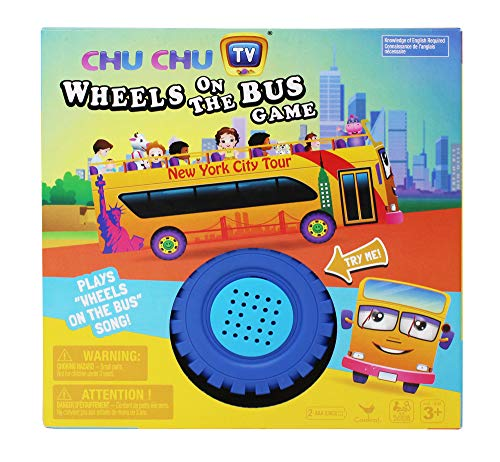

Alex Pretend Melody Mixer Piano Kids Music Activity - 
Image


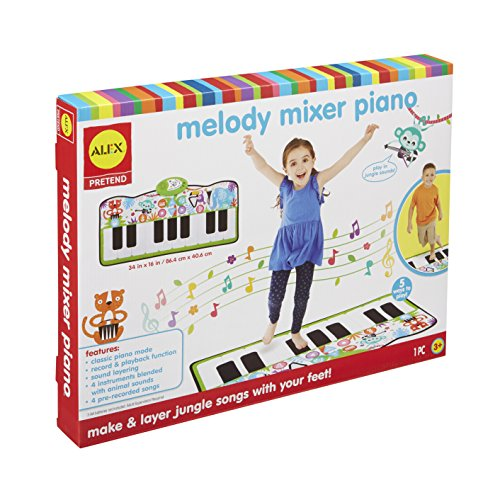

GreenPro 61 Key Portable Electronic Piano Keyboard LED Display with Adjustable Stand and Music Notes Holder - 
Image


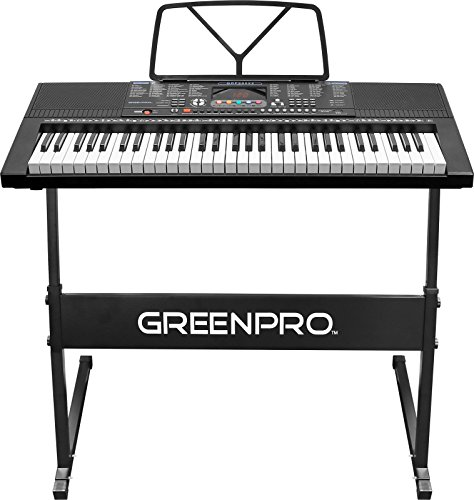

Kids Karaoke Machine with Microphone, Includes Musical Keyboard & Lights - Battery Operated Portable Singing Machine for Boys and Girls by Hey! Play! - 
Image


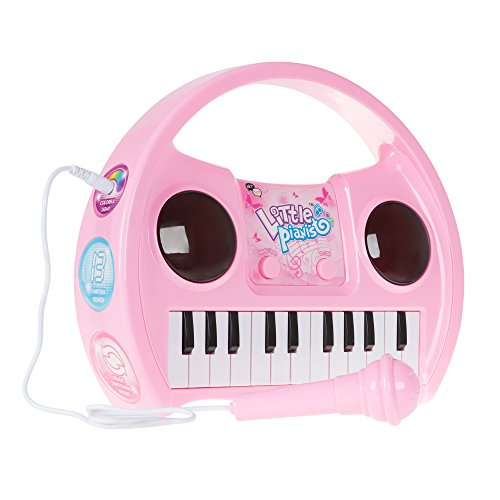

Mega Bloks ABC Musical Train Building Set, 50 pieces - 
Image


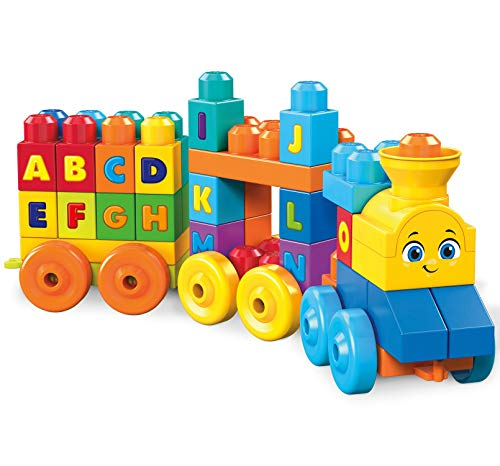

LeapFrog Dino's Delightful Day Alphabet Book, Green - 
Image


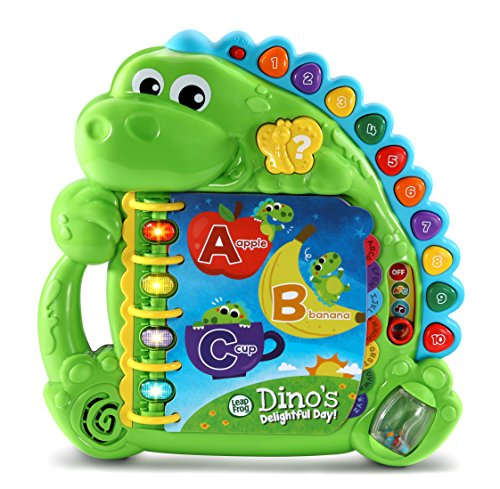

dreamGEAR My Arcade Learning Pad Educational Toy: 70 Brain and Puzzle Games, Over 200 Retro Style Games, Listen to Stories, Sing Songs, Play Games, 2.75 Inch Color Display, Battery Powered - 
Image


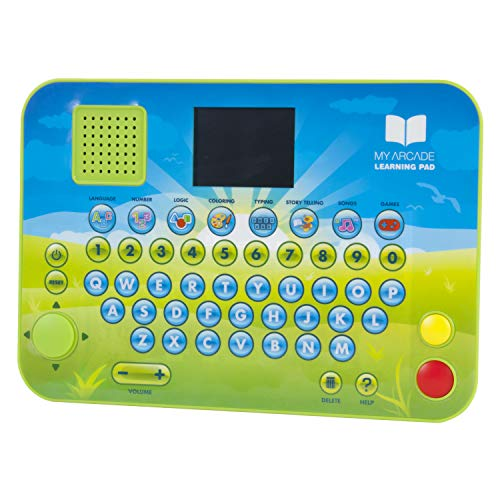

Hey! Play! 80-HJD931204 Wooden Musical Toy - 
Image


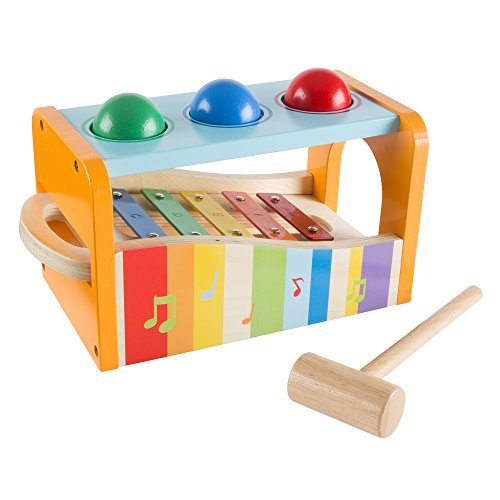

VTech Spinning Tunes Music Player - 
Image


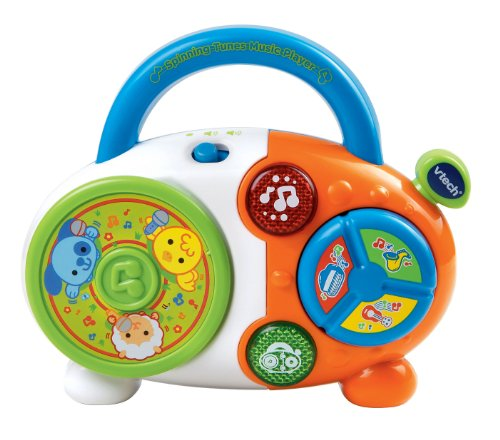

VTech Write and Learn Creative Center - 
Image


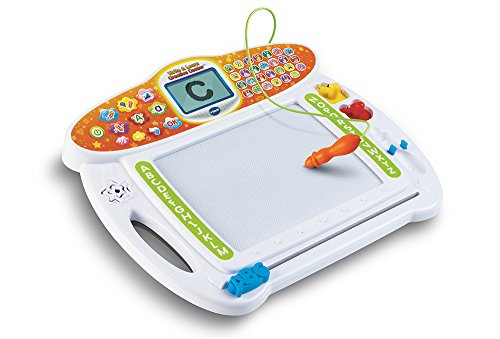

In [ ]:
# Function to display image from URL
def display_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    display(img)

# Step 5: Recommendation
# Function to get recommendations based on the product name
def get_recommendations(product_name, cosine_sim=cosine_sim):
    product_name = product_name.strip().lower()  # Remove leading/trailing spaces and convert to lowercase
    product_indices = df.index[df['Product Name'].str.strip().str.lower() == product_name].tolist()

    if not product_indices:
        print(f"No product found with the name '{product_name}'")
        return pd.DataFrame()  # Return an empty DataFrame

    idx = product_indices[0]  # Select the first index if multiple products match the name
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]  # Exclude the product itself
    product_indices = [i[0] for i in sim_scores]
    return df.iloc[product_indices]

# Function to get recommendations based on the product ID
def get_recommendations_from_id(product_id, cosine_sim=cosine_sim):
    product_row = df[df['Id'] == product_id]

    if product_row.empty:
        print(f"No product found with ID '{product_id}'")
        return pd.DataFrame()  # Return an empty DataFrame

    product_name = product_row.iloc[0]['Product Name']
    return get_recommendations(product_name, cosine_sim)

# Function to display recommendations for a given product ID
def display_recommendations_for_id(product_id):
    recommendations_from_id = get_recommendations_from_id(product_id)

    # Display recommendations
    if not recommendations_from_id.empty:
        print(f"Recommended products for ID {product_id}:")
        for _, row in recommendations_from_id.head(10).iterrows():
            print(f"{row['Product Name']} - \nImage")
            display_image_from_url(row['Image'])
    else:
        print("No recommendations found for the specified ID.")

# Example: Get recommendations for a product ID
display_recommendations_for_id(most_similar_image_id)
